SNR:  3.8564557054692967
Mean Squared Error:  0.19413964298867795


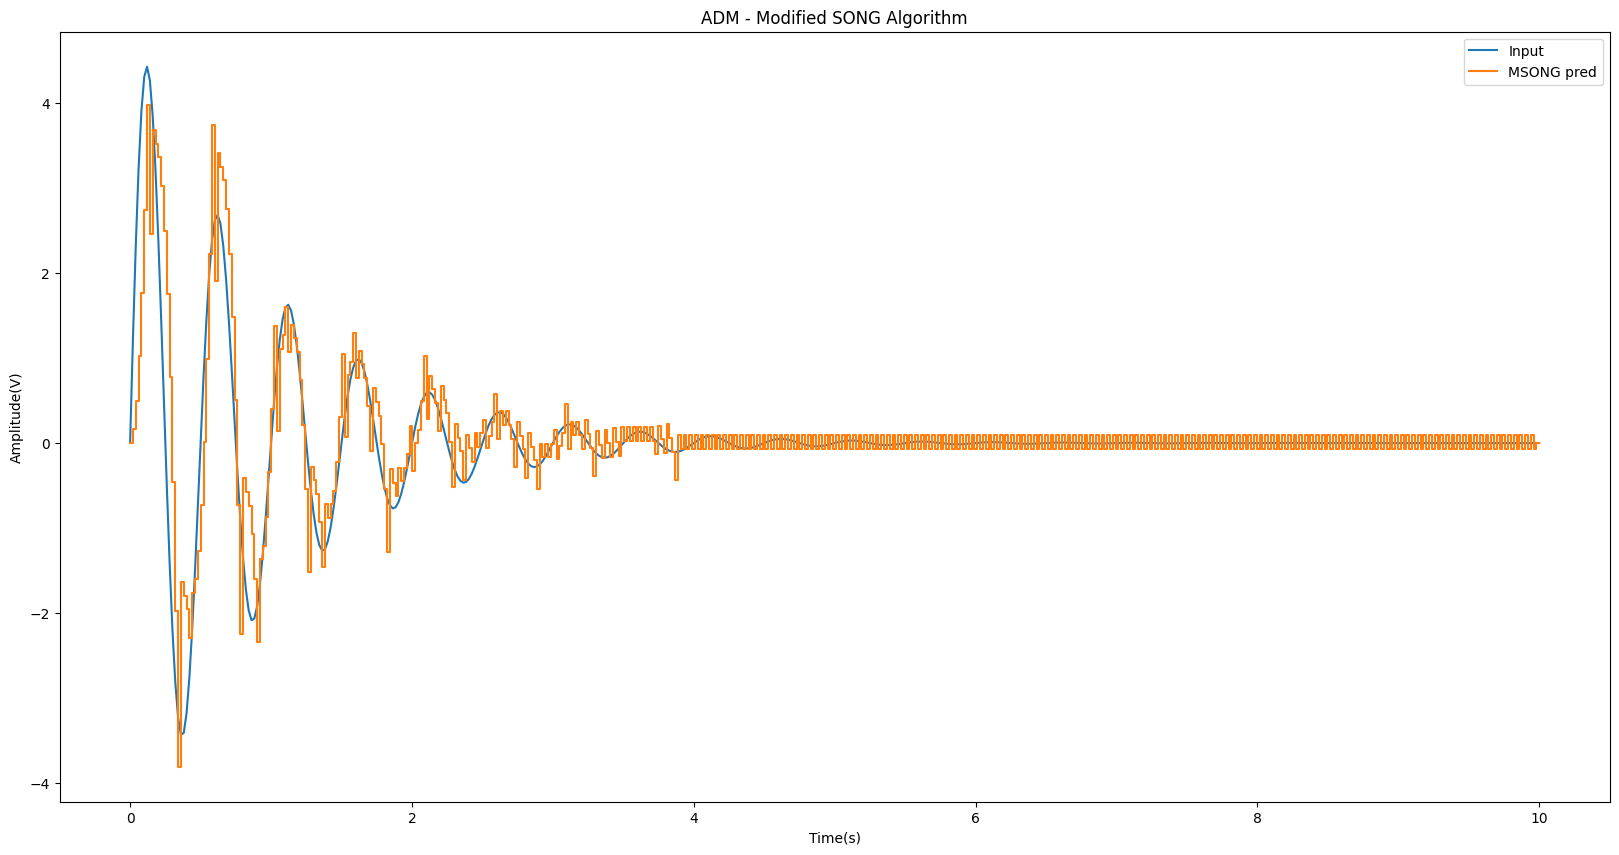

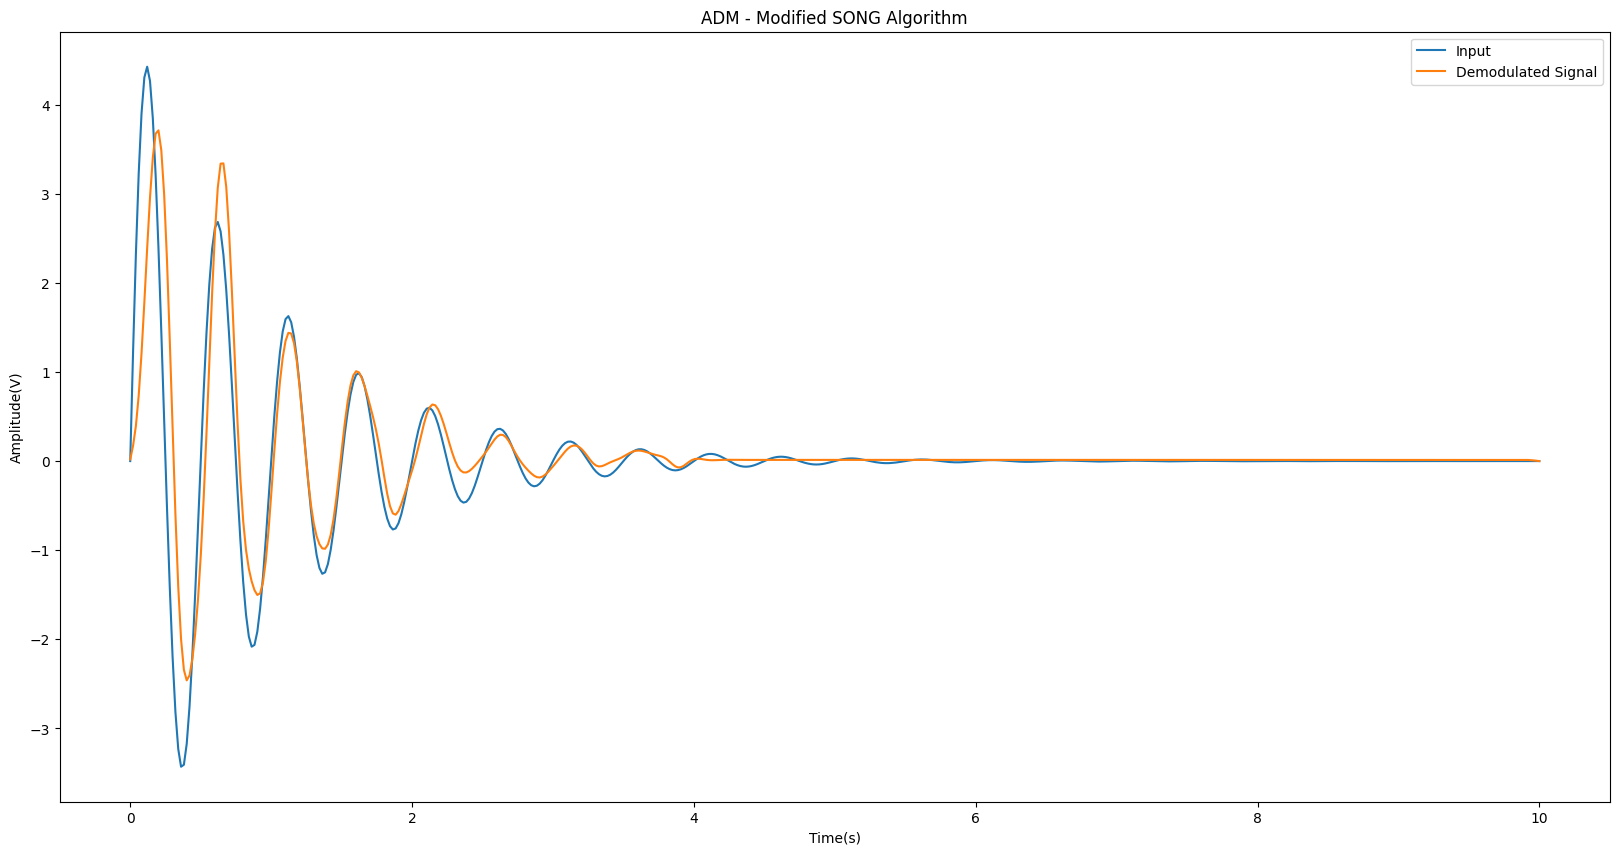

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def delta_msong(data, s0, a, b):
    # Modified SONG Algorithm
    len_data = len(data)
    step_size = np.zeros(len_data)
    pred = np.zeros(len_data)
    e_hat = np.zeros(len_data)

    for i in range(1, len_data-1):
        # Current Error e(n)
        e_n = data[i] - pred[i-1]
        # We are quantizing the error
        if e_n >= 0:
            e_hat[i] = 1
        else:
            e_hat[i] = -1

        # Applying Modified SONG Algorithm to change step_size
        if e_hat[i] == e_hat[i-1]:
            step_size[i+1] = (a*np.abs(step_size[i]) + s0)*e_hat[i]
        elif e_hat[i] != e_hat[i-1] and b*step_size[i] > s0:
            step_size[i+1] = (b*np.abs(step_size[i]) - s0)*e_hat[i]
        elif e_hat[i] != e_hat[i-1] and b*step_size[i] < s0:
            step_size[i+1] = s0*e_hat[i]

        # Accumulator
        pred[i] = pred[i-1] + e_hat[i]*np.abs(step_size[i])

    # Encoded data : 0 for -1 and 1 for +1
    encoded = e_hat >= 0
    return encoded, pred

def delta_msong_demod(mod_data, s0, a, b, f, fs):
    # Demodulator for Modified-SONG algorithm

    len_data = len(mod_data)
    x_dem = np.zeros(len_data)
    step_size = np.zeros(len_data)

    for i in range(1, len_data-1):
        # Encoded data to e_hat conversion
        if mod_data[i] == 0:
            e_hat = -1
        else:
            e_hat = 1

        x_dem[i] = e_hat*np.abs(step_size[i]) + x_dem[i-1]

        # Applying Modified SONG Algorithm to change step_size
        if mod_data[i] == mod_data[i-1]:
            step_size[i+1] = (a*np.abs(step_size[i]) + s0)*e_hat
        elif mod_data[i] != mod_data[i-1] and b*step_size[i] > s0:
            step_size[i+1] = (b*np.abs(step_size[i]) - s0)*e_hat
        elif mod_data[i] != mod_data[i-1] and b*step_size[i] < s0:
            step_size[i+1] = s0*e_hat

    # Reconstruction using low pass filter
    fs = 1000 # Sampling rate (Hz)
    fc = 100 # Cutoff frequency (Hz)
    order = 4 # Filter order

    b, a = butter(order, fc / (fs / 2), 'low')

    demod = filtfilt(b, a, x_dem)
    return demod

def isnr(x, y):
    # Calculate Signal-to-Noise Ratio (SNR) in dB
    noise = x - y
    mse = np.mean(np.square(noise))
    return 10 * np.log10(np.mean(np.square(x))/mse)

# Create signal
length = 500
t = np.linspace(0, 10, length)
Fs = 50
amp = 5
f = 2.0
x1 = amp * np.sin(2*np.pi*f*t) * np.exp(-t)

# Modulation
s0 = 0.16 #Minimum step size
a = 1.1 # We have chosen the best possible value for a through trial and error
b = 1/a
msong_out, msong_pred = delta_msong(x1, s0, a, 1/a);

# Demodulation
msong_demod = delta_msong_demod(msong_out, s0, a, 1/a, f, Fs);


dm_pred_snr1 = isnr(x1, msong_pred)
dm_demod_mse1 = np.mean(np.square(x1 - msong_demod))
print("SNR: ",dm_pred_snr1)
print("Mean Squared Error: ",dm_demod_mse1)

# Plot results
fig = plt.figure(figsize=(20, 10))
plt.plot(t, x1)
plt.step(t, msong_pred)
plt.title('ADM - Modified SONG Algorithm')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude(V)')
plt.legend(['Input', 'MSONG pred'])

fig2 = plt.figure(figsize=(20, 10))
plt.plot(t, x1)
plt.plot(t, msong_demod)
plt.title('ADM - Modified SONG Algorithm')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude(V)')
plt.legend(['Input', 'Demodulated Signal'])
